<a href="https://colab.research.google.com/github/XavierMorin/MonetCycleGan/blob/main/432_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
PATH='/content/drive/My Drive/Projet_comp432/Image/pictures.zip'
from zipfile import ZipFile
with ZipFile(PATH, 'r') as zipObj:
  # Extract all the contents of zip file in current directory
  zipObj.extractall()


In [ ]:
import pdb
import os
import pickle
import argparse
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Torch imports
import itertools
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

#Torch loaders
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

# Numpy & Scipy imports
import numpy as np
import scipy
import scipy.misc

# Local imports
import utils




def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True,dropout=False):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    if batch_norm:
        norm=nn.BatchNorm2d(out_channels,affine=True,track_running_stats=True)
        #norm=nn.InstanceNorm2d(out_channels,affine=False,track_running_stats=False)
        
        layers.append(norm)
         
       
    if dropout:
        layers.append(nn.Dropout2d(0.5,inplace=True))

    return nn.Sequential(*layers)


def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
   
    layers.append(conv_layer)

    if batch_norm:
        norm=nn.BatchNorm2d(out_channels,affine=True,track_running_stats=True)
        #norm=nn.InstanceNorm2d(out_channels,affine=False,track_running_stats=False)

        layers.append(norm)
       
    return nn.Sequential(*layers)
class ResnetBlock(nn.Module):
    def __init__(self, conv_dim):
        super(ResnetBlock, self).__init__()

        block=[
        nn.ReflectionPad2d(1),
        nn.Conv2d(conv_dim, conv_dim, kernel_size=3), 
        # nn.BatchNorm2d(conv_dim,affine=True,track_running_stats=True), 
        nn.InstanceNorm2d(conv_dim,affine=False,track_running_stats=False),
        nn.ReLU(True),
        # nn.Dropout(0.5),
        nn.ReflectionPad2d(1),
        nn.Conv2d(conv_dim, conv_dim, kernel_size=3), 
        # nn.BatchNorm2d(conv_dim,affine=True,track_running_stats=True)    
        nn.InstanceNorm2d(conv_dim,affine=False,track_running_stats=False)              
        ]
        
        self.block=nn.Sequential(*block)
       

    def forward(self, x):        
        out = x + self.block(x)
        return out

class Emoji_Discriminator(nn.Module):
  def __init__(self, conv_dim=32):
        super(emoji_Discriminator, self).__init__()
        #Before 32x32
        self.conv1=conv(3,conv_dim,4)
        #Before 16x16
        self.conv2=conv(conv_dim,conv_dim*2,4)
        #Before 8x8
        self.conv3=conv(conv_dim*2,conv_dim*4,4)
        #Before 4x4
        self.conv4=conv(conv_dim*4,1,4,batch_norm=False,stride=1,padding=0)
        #Out 1x1

  def forward(self, x):

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = self.conv4(out).squeeze()
        out = F.sigmoid(out)
        return out
class Scaled_Discriminator(nn.Module):
  '''
  Scaled up version of the Emoji_Discriminator to accept 256x256 images 
  but following the exact same logic.
  '''
  def __init__(self, conv_dim=32):
        super(Scaled_Discriminator, self).__init__()
        #Before 256x256
        self.conv1=conv(3,conv_dim,4,batch_norm=False)
        #Before 128x128
        self.conv2=conv(conv_dim,conv_dim*2,4)
        #Before 64x64
        self.conv3=conv(conv_dim*2,conv_dim*4,4)
        #Before 32x32
        self.conv4=conv(conv_dim*4,conv_dim*8,4)
        #Before 16x16
        self.conv5=conv(conv_dim*8,conv_dim*16,4)
        #Before 8x8
        self.conv6=conv(conv_dim*16,conv_dim*32,4)
        #Before 4x4
        self.conv7=conv(conv_dim*32,1,4,batch_norm=False,stride=1,padding=0)
        #Out 1x1

  def forward(self, x):

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.relu(self.conv5(out))
        out = F.relu(self.conv6(out))
        out = self.conv7(out).squeeze()
        out = F.sigmoid(out)
        return out


class Patch_Discriminator(nn.Module):
    """
    Defines the architecture of a Patch GAN Discriminator.
  
    """
    def __init__(self, conv_dim=64):
        super(Patch_Discriminator, self).__init__()
        #before 256x256
        self.conv1=conv(3,conv_dim,4,batch_norm=False)
        #before 128x128
        self.conv2=conv(conv_dim,conv_dim*2,4)
        #before 64x64
        self.conv3=conv(conv_dim*2,conv_dim*4,4)
        #before 32x32
        self.conv4=conv(conv_dim*4,conv_dim*8,4,stride=1,padding=1)
        #before 31x31
        self.conv5=conv(conv_dim*8,1,4,stride=1,padding=1,batch_norm=False)
        #Out 30x30

    def forward(self, x):

        out = F.leaky_relu(self.conv1(x),   inplace=True,negative_slope=0.2)
        out = F.leaky_relu(self.conv2(out), inplace=True,negative_slope=0.2)
        out = F.leaky_relu(self.conv3(out), inplace=True,negative_slope=0.2)
        out = F.leaky_relu(self.conv4(out), inplace=True,negative_slope=0.2)
        out = self.conv5(out)
        return out

class Emoji_Generator(nn.Module):
   def __init__(self, conv_dim=32):
        super(Emoji_Generator, self).__init__()

        self.conv1=conv(3,conv_dim,4)
       
        self.conv2=conv(conv_dim,conv_dim*2,4)
       
        self.resnet_block=ResnetBlock(conv_dim*2)
       
        self.deconv1= deconv(conv_dim*2,conv_dim,4)
       
        self.deconv2=deconv(conv_dim,3,4,batch_norm=False)

   def forward(self, x):
        """Generates an image conditioned on an input image.

        """
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.resnet_block(out))
        out = F.relu(self.deconv1(out))
        out = F.tanh(self.deconv2(out))

        return out

class Scaled_Generator(nn.Module):
   def __init__(self, conv_dim=32):
        super(Scaled_Generator, self).__init__()

        self.conv1=conv(3,conv_dim,4)
       
        self.conv2=conv(conv_dim,conv_dim*2,4)

        self.conv3=conv(conv_dim*2,conv_dim*4,4)

        self.resnet_block=ResnetBlock(conv_dim*4)
       
        self.deconv1= deconv(conv_dim*4,conv_dim*2,4)

        self.deconv2= deconv(conv_dim*2,conv_dim,4)
       
        self.deconv3=deconv(conv_dim,3,4,batch_norm=False)

   def forward(self, x):
        """Generates an image conditioned on an input image.

        """
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.resnet_block(out))
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.tanh(self.deconv3(out))

        return out

class Resnet_Generator(nn.Module):
  def __init__(self, conv_dim=64):
        '''
        Code for the Resnet Generator is strongly inspired by the code 
        found here https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
        '''
        super(Resnet_Generator, self).__init__()
         # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(3, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(9):
            model += [ResnetBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, 3, 7),
                    nn.Tanh() ]

        self.block = nn.Sequential(*model)
  def forward(self,x):
        return self.block(x)



class UNet_Generator(nn.Module):
    """
    Defines the architecture of the generator network.
    Note: Both generators G_XtoY and G_YtoX have the same architecture in this assignment.
    Inspired by https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/
    """
    def __init__(self, conv_dim=64):
        super(U-Net_Generator, self).__init__()
        '''Test 3'''
        #Encoder Part
        self.conv1=conv(3,conv_dim,4,batch_norm=False)
        self.conv2=conv(conv_dim  ,conv_dim*2,4)
        self.conv3=conv(conv_dim*2,conv_dim*4,4)
        self.conv4=conv(conv_dim*4,conv_dim*8,4)

        #Transformer part
        self.conv5=conv(conv_dim*8,conv_dim*8,4)
        self.conv6=conv(conv_dim*8,conv_dim*8,4)
        self.conv7=conv(conv_dim*8,conv_dim*8,4)
        self.conv8=conv(conv_dim*8,conv_dim*8,4)
       
        self.deconv1= deconv(conv_dim*8,conv_dim*8,4,dropout=True)
        self.deconv2= deconv(conv_dim*8*2,conv_dim*8,4,dropout=True)
        self.deconv3= deconv(conv_dim*8*2,conv_dim*8,4,dropout=True)
        self.deconv4= deconv(conv_dim*8*2,conv_dim*8,4)

        #Decoder Part
        self.deconv5=deconv(conv_dim*8*2,conv_dim*4,4)
        self.deconv6=deconv(conv_dim*4*2,conv_dim*2,4)
        self.deconv7=deconv(conv_dim*2*2,conv_dim,4)
        self.deconv8=deconv(conv_dim*2,3,4,batch_norm=False)

       
    def forward(self, x):
        """Generates an image conditioned on an input image.
        """
        '''Test 3'''
        #Encoder
        out1 = F.leaky_relu(self.conv1(x)   ,inplace=True,negative_slope=0.2)
        out2 = F.leaky_relu(self.conv2(out1),inplace=True,negative_slope=0.2)
        out3 = F.leaky_relu(self.conv3(out2),inplace=True,negative_slope=0.2)
        out4 = F.leaky_relu(self.conv4(out3),inplace=True,negative_slope=0.2)

        #Transformer
        out5 = F.leaky_relu(self.conv5(out4),inplace=True,negative_slope=0.2)
        out6 = F.leaky_relu(self.conv6(out5),inplace=True,negative_slope=0.2)
        out7 = F.leaky_relu(self.conv7(out6),inplace=True,negative_slope=0.2)
        out8 = F.leaky_relu(self.conv8(out7),inplace=True,negative_slope=0.2)

        dout1 = F.relu(self.deconv1(out8))
        dout1_out7=torch.cat([dout1, out7], 1)
        dout2 = F.relu(self.deconv2(dout1_out7))
        dout2_out6 = torch.cat([dout2, out6], 1)
        dout3 = F.relu(self.deconv3(dout2_out6))
        dout3_out5 = torch.cat([dout3, out5], 1)
        dout4 = F.relu(self.deconv4(dout3_out5))
        dout4_out4 = torch.cat([dout4, out4], 1)

        #Decoder
        dout5 = F.relu(self.deconv5(dout4_out4))
        dout5_out3 = torch.cat([dout5, out3], 1)
        dout6 = F.relu(self.deconv6(dout5_out3))
        dout6_out2 = torch.cat([dout6, out2], 1)
        dout7 = F.relu(self.deconv7(dout6_out2))
        dout7_out1 = torch.cat([dout7, out1], 1)
        out = F.tanh(self.deconv8(dout7_out1))

        return out


Models moved to GPU.


StopIteration: ignored

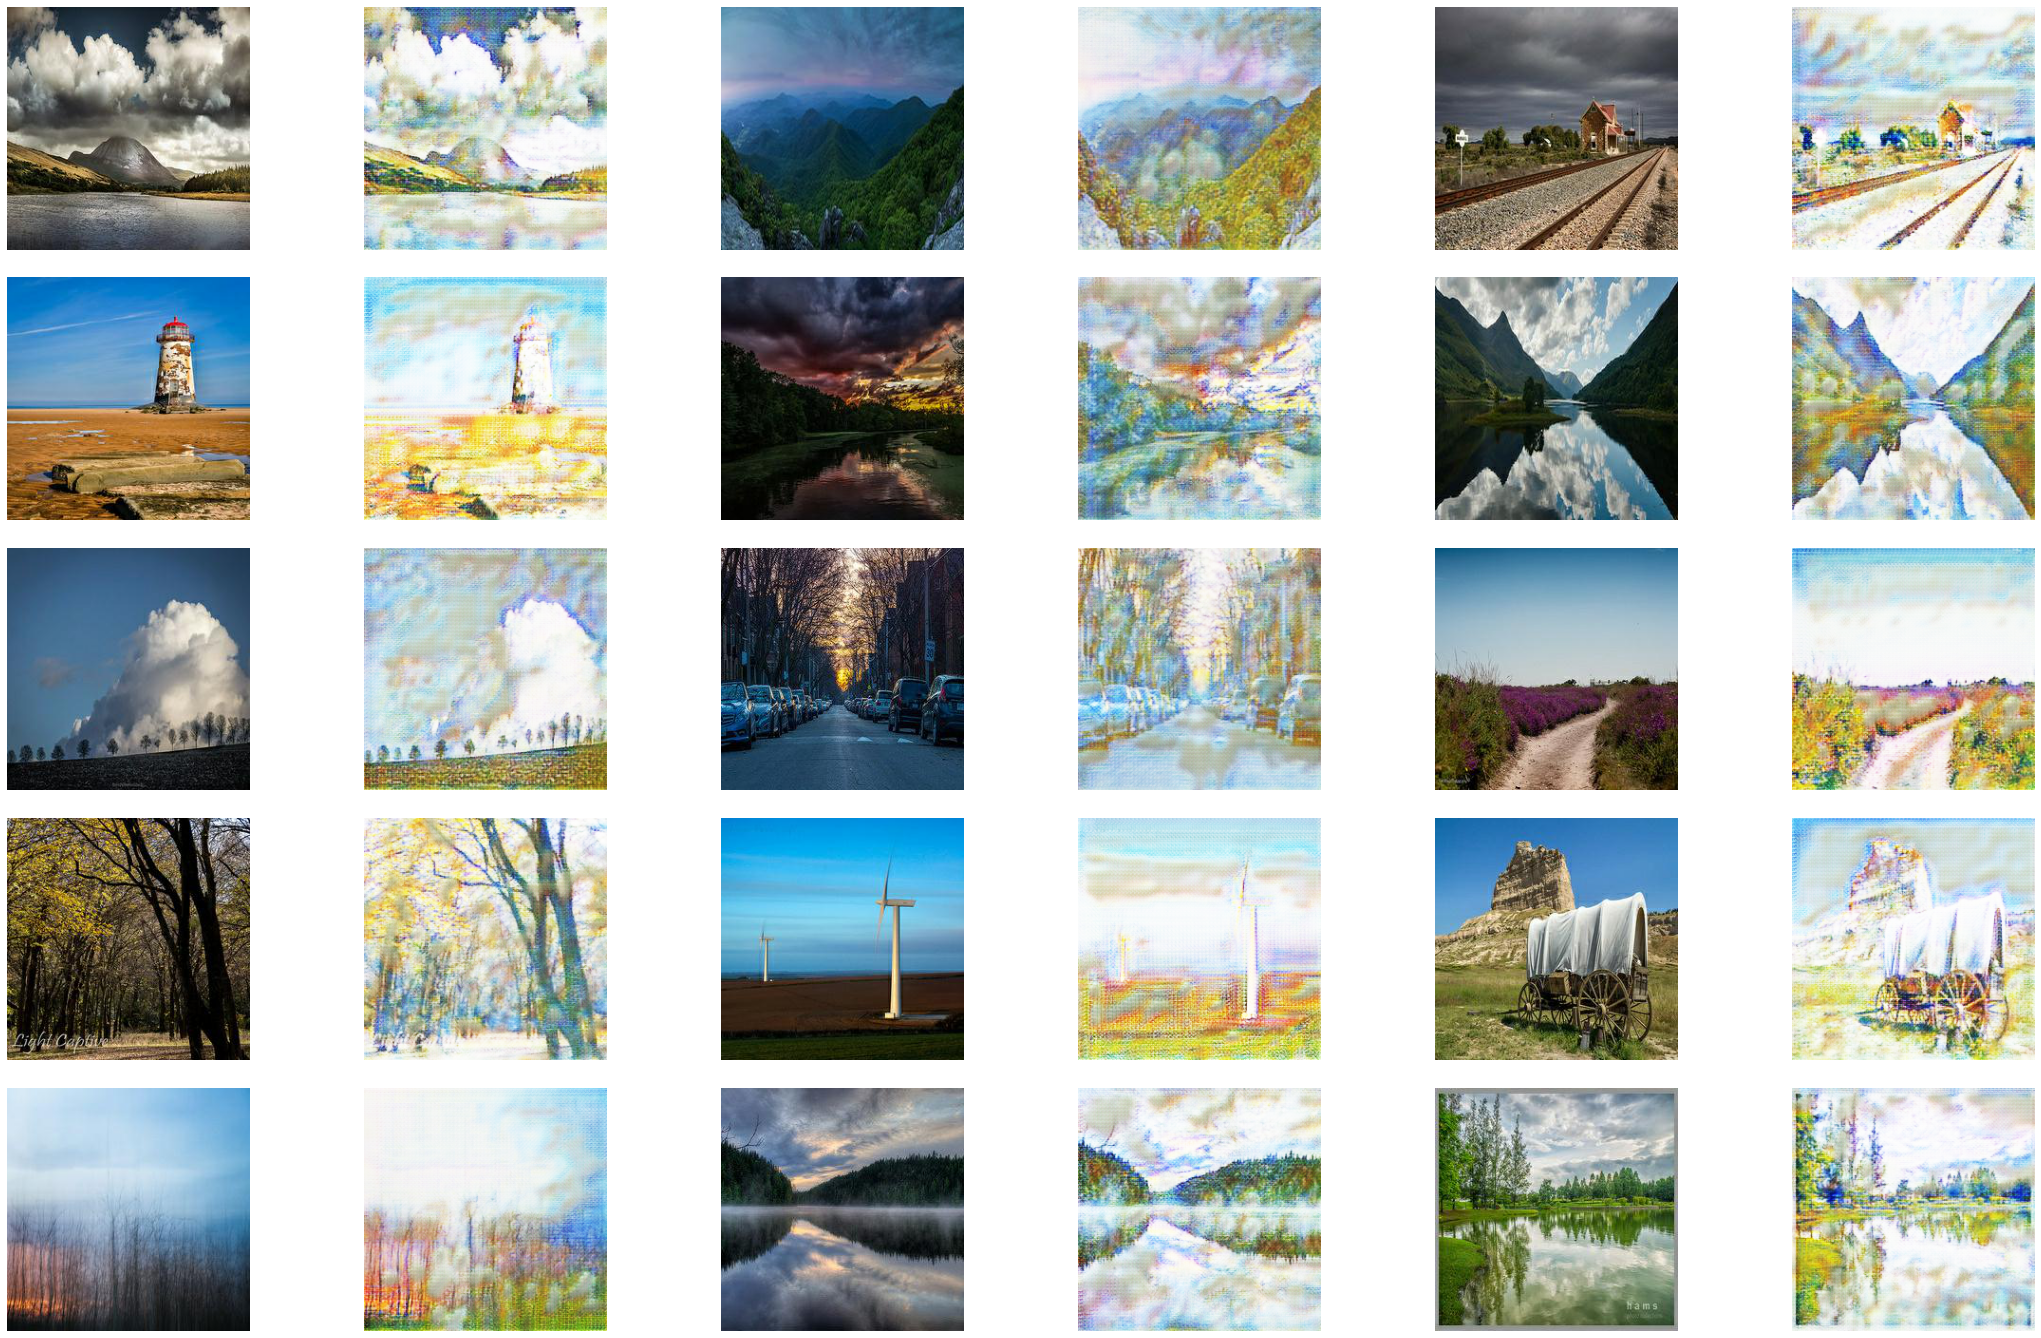

In [ ]:



# Set the random seed manually for reproducibility.
#The structure of the code come from an Assigment from Toronto University 
SEED = 36

import random
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
# def augment_data(data_loader):

def get_pictures(type_,opts,data_augmentation=False):
    """Creates training and test data loaders.
    """
  
    transform = transforms.Compose([
                    transforms.Scale(opts['image_size']),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])
    if data_augmentation:
       transform1 = transforms.Compose([
                    transforms.Scale(opts['image_size']),
                    transforms.RandomHorizontalFlip(p=1),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    
                ])
       transform2 = transforms.Compose([
                    transforms.Scale(opts['image_size']),
                    transforms.RandomVerticalFlip(p=1),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   
                ])
       


    train_path = os.path.join('pictures', type_)
    test_path = os.path.join('pictures', 'Test_{}'.format(type_))

    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    if data_augmentation:
      train_dataset1=datasets.ImageFolder(train_path, transform1)
      train_dataset2=datasets.ImageFolder(train_path, transform2)
      train_dataset=torch.utils.data.ConcatDataset([train_dataset,train_dataset1,train_dataset2])
      

    train_dloader = DataLoader(dataset=train_dataset, batch_size=opts['batch_size'], shuffle=True)
    test_dloader = DataLoader(dataset=test_dataset, batch_size=opts['batch_size'], shuffle=False)
   
      

      
    return train_dloader, test_dloader
def get_pictures_2(opts):
  transform = transforms.Compose([
                    transforms.Scale(opts['image_size']),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])
  test_dataset = datasets.ImageFolder(os.path.join(opts['sample_dir'],''), transform)
  test_dloader = DataLoader(dataset=test_dataset, batch_size=opts['batch_size'], shuffle=False)
  return test_dloader
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                 G_XtoY                ")
    print("---------------------------------------")
    print(G_XtoY)
    print("---------------------------------------")

    print("                 G_YtoX                ")
    print("---------------------------------------")
    print(G_YtoX)
    print("---------------------------------------")

    print("                  D_X                  ")
    print("---------------------------------------")
    print(D_X)
    print("---------------------------------------")

    print("                  D_Y                  ")
    print("---------------------------------------")
    print(D_Y)
    print("---------------------------------------")


def create_model(opts):
    """Builds the generators and discriminators.
    """
    if opts['Generator']=='U-Net':
      G_XtoY = UNet_Generator(conv_dim=opts['g_conv_dim'])
      G_YtoX = UNet_Generator(conv_dim=opts['g_conv_dim'])
    if opts['Generator']=='Resnet':
      G_XtoY = Resnet_Generator(conv_dim=opts['g_conv_dim'])
      G_YtoX = Resnet_Generator(conv_dim=opts['g_conv_dim'])
    if opts['Generator']=='Scale':
      G_XtoY = Scaled_Generator(conv_dim=opts['g_conv_dim'])
      G_YtoX = Scaled_Generator(conv_dim=opts['g_conv_dim'])
    if opts['Generator']=='Emoji':
      G_XtoY = Emoji_Generator(conv_dim=opts['g_conv_dim'])
      G_YtoX = Emoji_Generator(conv_dim=opts['g_conv_dim'])

    
    if opts['Discriminator']=='Patch':
      D_X = Patch_Discriminator(conv_dim=opts['d_conv_dim'])
      D_Y = Patch_Discriminator(conv_dim=opts['d_conv_dim'])
    if opts['Discriminator']=='Scale':
      D_X = Scaled_Discriminator(conv_dim=opts['d_conv_dim'])
      D_Y = Scaled_Discriminator(conv_dim=opts['d_conv_dim'])
    if opts['Discriminator']=='Emoji':
      D_X = Emoji_Discriminator(conv_dim=opts['d_conv_dim'])
      D_Y = Emoji_Discriminator(conv_dim=opts['d_conv_dim'])

    
    if opts['init_zero_weights']:
      G_XtoY.apply(utils.weights_init_normal)
      G_YtoX.apply(utils.weights_init_normal)
      D_X.apply(utils.weights_init_normal)
      D_Y.apply(utils.weights_init_normal)
      print('Weights Initialized')   

    print_models(G_XtoY, G_YtoX, D_X, D_Y)

    if torch.cuda.is_available():
        G_XtoY.cuda()
        G_YtoX.cuda()
        D_X.cuda()
        D_Y.cuda()
        print('Models moved to GPU.')
    
    

    return G_XtoY, G_YtoX, D_X, D_Y


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, opts):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
    """

    G_XtoY_path = os.path.join(opts['checkpoint_dir'], 'G_XtoY_scale_patch.pkl')
    G_YtoX_path = os.path.join(opts['checkpoint_dir'], 'G_YtoX_cscale_patch.pkl')
    D_X_path = os.path.join(opts['checkpoint_dir'], 'D_X_scale_patch.pkl')
    D_Y_path = os.path.join(opts['checkpoint_dir'], 'D_Y_scale_patch.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def load_checkpoint(opts):
    """Loads the generator and discriminator models from checkpoints.
    """
    # G_XtoY_path = os.path.join(opts['load'], 'G_XtoY_{:s}.pkl'.format(opts['load_name']))
    G_YtoX_path = os.path.join(opts['load'], '{:s}.pkl'.format(opts['load_name']))
    # D_X_path = os.path.join(opts['load'], 'D_X_{:s}.pkl'.format(opts['load_name']))
    # D_Y_path = os.path.join(opts['load'], 'D_Y_{:s}.pkl'.format(opts['load_name']))

    if opts['Generator']=='U-Net':
      G_XtoY = UNet_Generator(conv_dim=opts['g_conv_dim'])
      G_YtoX = UNet_Generator(conv_dim=opts['g_conv_dim'])
    if opts['Generator']=='Resnet':
      G_XtoY = Resnet_Generator(conv_dim=opts['g_conv_dim'])
      G_YtoX = Resnet_Generator(conv_dim=opts['g_conv_dim'])
    if opts['Generator']=='Scale':
      G_XtoY = Scaled_Generator(conv_dim=opts['g_conv_dim'])
      G_YtoX = Scaled_Generator(conv_dim=opts['g_conv_dim'])
    if opts['Generator']=='Emoji':
      G_XtoY = Emoji_Generator(conv_dim=opts['g_conv_dim'])
      G_YtoX = Emoji_Generator(conv_dim=opts['g_conv_dim'])

    # if opts['Discriminator']=='Patch':
    #   D_X = Patch_Discriminator(conv_dim=opts['d_conv_dim'])
    #   D_Y = Patch_Discriminator(conv_dim=opts['d_conv_dim'])
    # if opts['Discriminator']=='Scale':
    #   D_X = Scaled_Discriminator(conv_dim=opts['d_conv_dim'])
    #   D_Y = Scaled_Discriminator(conv_dim=opts['d_conv_dim'])
    # if opts['Discriminator']=='Emoji':
    #   D_X = Emoji_Discriminator(conv_dim=opts['d_conv_dim'])
    #   D_Y = Emoji_Discriminator(conv_dim=opts['d_conv_dim'])

    # G_XtoY.load_state_dict(torch.load(G_XtoY_path, map_location=lambda storage, loc: storage),strict=False)
    G_YtoX.load_state_dict(torch.load(G_YtoX_path, map_location=lambda storage, loc: storage),strict=False)
    # D_X.load_state_dict(torch.load(D_X_path, map_location=lambda storage, loc: storage),strict=False)
    # D_Y.load_state_dict(torch.load(D_Y_path, map_location=lambda storage, loc: storage),strict=False)

    if torch.cuda.is_available():
        # G_XtoY.cuda()
        G_YtoX.cuda()
        # D_X.cuda()
        # D_Y.cuda()
        print('Models moved to GPU.')

    return  G_YtoX#,G_XtoY, D_X, D_Y


def merge_images(sources, targets ,opts,cycle=None, k=10):
    """Creates a grid consisting of pairs of columns, where the first column in
    each pair contains images source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """
    _, _, h, w = sources.shape
    if opts['batch_size']<4:
      row=opts['batch_size']
    else:
      row = int(np.sqrt(opts['batch_size']))
    if cycle is not None:
      merged = np.zeros([3, row*h, row*w*3])
     
      for idx, (s, t,c) in enumerate(zip(sources, targets,cycle)):
          i = idx // row
          j = idx % row
         
          merged[:, i*h:(i+1)*h, (j*3)*h:(j*3+1)*h] = s
          merged[:, i*h:(i+1)*h, (j*3+1)*h:(j*3+2)*h] = t
          merged[:, i*h:(i+1)*h, (j*3+2)*h:(j*3+3)*h] = c
    else:
      merged = np.zeros([3, row*h, row*w*2])

      for idx, (s, t) in enumerate(zip(sources, targets)):
          i = idx // row
          j = idx % row
          merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
          merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t

    return merged.transpose(1, 2, 0)
def visualise(opts):
  # G_XtoY, G_YtoX, D_X, D_Y=load_checkpoint(opts)
  G_YtoX=load_checkpoint(opts)
  test_dataloader_Y = get_pictures_2(opts)
  #dataloader_X, test_dataloader_X = get_pictures(type_='monet', opts=opts)

  
  test_iter_Y = iter(test_dataloader_Y)
  #test_iter_X = iter(test_dataloader_X)
  fixed_Y = utils.to_var(test_iter_Y.next()[0])
  #fixed_X = utils.to_var(test_iter_X.next()[0])
  # save_samples(0, fixed_Y, fixed_X, G_XtoY, G_YtoX, opts)

  b_size=opts['batch_size']
  plt.figure(figsize=(30,75))   
      
  im_x=G_YtoX.forward(fixed_Y)


  Y,fake_X= utils.to_data(fixed_Y),utils.to_data(im_x)
  for j in range(1,17):
    if j%b_size==0:
      fixed_Y = utils.to_var(test_iter_Y.next()[0])
      im_x=G_YtoX.forward(fixed_Y)
     
      Y,fake_X= utils.to_data(fixed_Y),utils.to_data(im_x)

    plt.subplot(20,6,j*2-1)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow((Y[j%b_size-1].transpose(1, 2, 0)+1)/2)
    plt.subplot(20,6,j*2)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow((fake_X[j%b_size-1].transpose(1, 2, 0)+1)/2)
   

def update_pool(pool, images, max_size=50):
  return_images = []
  for image in images:
      image = torch.unsqueeze(image.data, 0)
      if len(pool) < max_size:   # if the buffer is not full; keep inserting current images to the buffer
          
          pool.append(image)
          return_images.append(image)
      else:
          p = random.uniform(0, 1)
          if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
              random_id = random.randint(0, len(pool) - 1)  # randint is inclusive
              tmp = pool[random_id].clone()
              pool[random_id] = image
              return_images.append(tmp)
          else:       # by another 50% chance, the buffer will return the current image
              return_images.append(image)
  return_images = torch.cat(return_images, 0)   # collect all the images and return
  return return_images

def save_samples(iteration, fixed_Y, fixed_X, G_XtoY, G_YtoX, opts):
    """Saves samples from both generators X->Y and Y->X.
    """
    fake_X = G_YtoX(fixed_Y)
    fake_Y = G_XtoY(fixed_X)

    cycle_Y = G_XtoY(fake_X)
    cycle_X = G_YtoX(fake_Y)

    X, fake_X, cycle_X = utils.to_data(fixed_X), utils.to_data(fake_X), utils.to_data(cycle_X)
    Y, fake_Y, cycle_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), utils.to_data(cycle_Y)

    merged =( merge_images(X, fake_Y, opts,cycle_X)+1)/2
    path = os.path.join(opts['sample_dir'], 'sample-{:06d}-X-Y.png'.format(iteration))
    plt.imsave(path, merged)
    print('Saved {}'.format(path))

    merged =(merge_images(Y, fake_X, opts,cycle_Y)+1)/2
    path = os.path.join(opts['sample_dir'], 'sample-{:06d}-Y-X.png'.format(iteration))
    plt.imsave(path, merged)
    print('Saved {}'.format(path))


def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """

    # Create generators and discriminators
    if opts['load']:
        G_XtoY, G_YtoX, D_X, D_Y = load_checkpoint(opts)
    else:
        G_XtoY, G_YtoX, D_X, D_Y = create_model(opts)

    g_params =  list(G_YtoX.parameters())+list(G_XtoY.parameters())   # Get generator parameters
    d_X_params = D_X.parameters()
    d_Y_params = D_Y.parameters()

    # Create optimizers for the generators and discriminators
    g_optimizer   = optim.Adam(g_params  , opts['lr'], [opts['beta1'], opts['beta2']])
    d_X_optimizer = optim.Adam(d_X_params, opts['lr'], [opts['beta1'], opts['beta2']])
    d_Y_optimizer = optim.Adam(d_Y_params, opts['lr'], [opts['beta1'], opts['beta2']])
    
    if opts['Scheduler']:
      lambda_1=lambda iteration:1-iteration/opts['train_iters']

      lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(g_optimizer    , lr_lambda=lambda_1)
      lr_scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(d_X_optimizer, lr_lambda=lambda_1)
      lr_scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(d_Y_optimizer, lr_lambda=lambda_1)

    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    print('dataset_x ',len(dataloader_X.dataset))
    print('dataset_y ',len(dataloader_Y.dataset))

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)


    if opts['D_loss']=='BCE':
      d_loss =nn.BCEWithLogitsLoss()
    elif opts['D_loss']=='MSE':
      d_loss=torch.nn.MSELoss()

    if opts['Cycle_loss']=='L1':
      cycle_loss =nn.L1Loss()
    elif opts['Cycle_loss']=='L2':
      cycle_loss =nn.L2Loss()

    
    lambda_=opts['lambda']
    patch_size=1
    if opts['Discriminator']=='Patch':
      if opts['image_size']==256:
        patch_size=30
      elif opts['image_size']==128:
        patch_size=14
      elif opts['image_size']==64:
        patch_size=6
      else:
        raise "Image format not supported for patch_discriminator"
      
    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = utils.to_var(test_iter_X.next()[0])
    fixed_Y = utils.to_var(test_iter_Y.next()[0])

    pool_fake_X=list()
    pool_fake_Y=list()
    
    for iteration in range(1, opts['train_iters']+1):

        # Reset data_iter for each epoch
        # Loads only one batch at a time on the GPU
        try:
          images_X, labels_X = iter_X.next()
        except:
          iter_X=iter(dataloader_X)
          images_X, labels_X = iter_X.next()

        images_X, labels_X = utils.to_var(images_X), utils.to_var(labels_X).long().squeeze()

        try:
          images_Y, labels_Y = iter_Y.next()
        except:
          iter_Y=iter(dataloader_Y)
          images_Y, labels_Y = iter_Y.next()

        images_Y, labels_Y = utils.to_var(images_Y), utils.to_var(labels_Y).long().squeeze()

    
        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================
        #Active the gradient for the discriminators
        for net in [D_X,D_Y]:
          for param in net.parameters():
            param.requires_grad = True
       
        # Train with real images
        
        # 1. Compute the discriminator losses on real images
        D_X_real_loss = d_loss(D_X(images_X),utils.to_var(torch.ones((images_X.shape[0],1,patch_size,patch_size))))
        D_Y_real_loss = d_loss(D_Y(images_Y),utils.to_var(torch.ones((images_Y.shape[0],1,patch_size,patch_size))))

        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
        fake_X = update_pool(pool_fake_X,fake_X,50*opts['batch_size'])
     
        # 3. Compute the loss for D_X
        D_X_fake_loss = d_loss(D_X(fake_X),utils.to_var(torch.zeros((images_Y.shape[0],1,patch_size,patch_size))))

        # 4. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)
        fake_Y = update_pool(pool_fake_Y,fake_Y,50*opts['batch_size'])
        
        # 5. Compute the loss for D_Y
        D_Y_fake_loss = d_loss(D_Y(fake_Y),utils.to_var(torch.zeros((images_X.shape[0],1,patch_size,patch_size))))

        # 6.Compute total loss for D_X and backpropagate
        d_X_total_loss=(D_X_real_loss+D_X_fake_loss)/2
        d_X_optimizer.zero_grad()
        d_X_total_loss.backward()
        d_X_optimizer.step()

        # 7.Compute total loss for D_Y and backpropagate
        d_Y_total_loss=(D_Y_real_loss+D_Y_fake_loss)/2
        d_Y_optimizer.zero_grad()
        d_Y_total_loss.backward()
        d_Y_optimizer.step()
       

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        #Desactive the gradient for the discriminators, not necessary, saves computation
        for net in [D_X,D_Y]:
          for param in net.parameters():
            param.requires_grad = False
       
        #########################################
        ##          X--Y-->X CYCLE             ##
        #########################################

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY.forward(images_X)
     
        # 2. Compute the generator loss based on domain Y
        g_XtoY_loss = d_loss(D_Y(fake_Y),utils.to_var(torch.ones((images_X.shape[0],1,patch_size,patch_size))))
             
        # 3. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        cycle_consistency_loss =cycle_loss(images_X,reconstructed_X)
        g_XtoY_cycle_loss = lambda_*cycle_consistency_loss

        # 4.Compute Identity Loss
        id_XtoY=G_XtoY(images_Y)
        identity_XtoY_loss=lambda_/2*cycle_loss(images_Y,id_XtoY)

       
        #########################################
        ##          Y--X-->Y CYCLE             ##
        #########################################

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
  
        # 2. Compute the generator loss based on domain X
        g_YtoX_loss = d_loss(D_X(fake_X),utils.to_var(torch.ones((images_Y.shape[0],1,patch_size,patch_size))))

        # 3. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        cycle_consistency_loss =cycle_loss(images_Y,reconstructed_Y)
        g_YtoX_cycle_loss = lambda_*cycle_consistency_loss

        # 4.Compute Identity Loss
        id_YtoX=G_YtoX(images_X)
        identity_YtoX_loss=lambda_/2*cycle_loss(images_X,id_YtoX)
       
       
        #Calculate Total loss for the Generator and backpropagate
        g_loss= g_XtoY_loss + g_XtoY_cycle_loss+ identity_XtoY_loss + g_YtoX_loss + g_YtoX_cycle_loss+identity_YtoX_loss
        #g_loss= g_XtoY_loss + g_YtoX_loss 
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        #########################################
        ##             Schedulers              ##
        #########################################

        # Step Schedulers
        if opts['Scheduler']:
          lr_scheduler_G.step() 
          lr_scheduler_D_X.step()
          lr_scheduler_D_Y.step()

        #########################################
        ## Print, Save samples and checkpoints ##
        #########################################
        

        # Print the log info
        if iteration % opts['log_step'] == 0:
            print('Iteration [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_XtoY_loss: {:6.4f} | '
                  'g_YtoX_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    iteration, opts['train_iters'], d_X_total_loss.item(),d_Y_total_loss.item(), g_XtoY_loss.item(),
                    g_YtoX_loss.item(), g_loss.item()))


        # Save the generated samples
        if iteration % opts['sample_every'] == 0:
            save_samples(iteration, fixed_Y, fixed_X, G_XtoY, G_YtoX, opts)


        # Save the model parameters
        if iteration % opts['checkpoint_every'] == 0:
            checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, opts)


def main(opts):
    """Loads the data, creates checkpoint and sample directories, and starts the training loop.
    """
   
    # Create train and test dataloaders for images from the two domains X and Y
    dataloader_X, test_dataloader_X = get_pictures(type_='monet', opts=opts,data_augmentation=True)
    dataloader_Y, test_dataloader_Y = get_pictures(type_='photo', opts=opts)

    # Create checkpoint and sample directories
    utils.create_dir(opts['checkpoint_dir'])
    utils.create_dir(opts['sample_dir'])

    # Start training
    training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, opts)

if __name__ == '__main__':

    opts = {'image_size':256,
            'g_conv_dim':64,
            'd_conv_dim':64,
            #Generators: Emoji, Scale, U-Net, Resnet 
            'Generator':'Resnet', 
            #Discriminators: Emoji, Scale, Patch
            'Discriminator':'Patch',
            #Normalization :BatchNorm or InstanceNorm
            'norm':'BatchNorm',
            #Dsicriminator's Loss: MSE  or BCE
            'D_loss':'MSE',
            #Cycle and Identity Losses: L1 or L2
            'Cycle_loss':'L1',
            'lambda':10,
            # Init weight of Conv, Deconv and BatchNorm
            'init_zero_weights':True,
            'Scheduler':False,
            'train_iters':40000,
            'batch_size':1, 
            'lr':0.0002,
            'beta1':0.5,
            'beta2':0.999,
            'checkpoint_dir':'',
            'sample_dir':'test_image',
            'load':'',
            'load_name':'PictureToMonet',
            'log_step':10,
            'sample_every':90,
            'checkpoint_every': 800,
            'load_checkpoint':True
            }


    if opts['load_checkpoint']:
       visualise(opts)
    else:    
      if opts['load']:
          opts['sample_dir'] = '{}_pretrained'.format( opts['sample_dir'])
          opts['sample_every'] = 180
      main(opts)
